In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.linalg import expm
import time
matplotlib.font_manager.fontManager.addfont("fonts/ipag.ttf")
matplotlib.rcParams['font.family'] = 'IPAGothic'

In [54]:
# シミュレーションパラメータ
total_time = 0.25*np.pi # ns
n_steps = 50 #時間スライス数
dt = total_time / n_steps #スライス幅

# パウリ行列
sx = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)
identity = np.eye(2, dtype=np.complex128)

# 2 Qubitのminimal set(イジング相互作用)
xi = np.kron(sx, identity)
yi = np.kron(sy, identity)
ix = np.kron(identity, sx)
iy = np.kron(identity, sy)
zz = np.kron(sz, sz)

# 状態
down = np.array([[0], [1]], dtype=np.complex128)  # |1⟩
up = np.array([[1], [0]], dtype=np.complex128)    # |0⟩

# ハミルトニアン
H_controls = [xi, yi, ix, iy, zz]
H_drift =  np.kron(np.zeros((2, 2), dtype=np.complex128), np.zeros((2, 2), dtype=np.complex128))

In [55]:
initial_state = np.kron(up, up)
target_state = np.kron(down, up)

# コスト関数
def fidelity(arbitrary_state: np.ndarray, target_state: np.ndarray):
    """
    コスト関数を計算する
    
    """
    F = np.abs(target_state.conj().T @ arbitrary_state)[0, 0]**2
    return F

# 順伝播
def forward_propagation(pulses: list, initial_state: np.ndarray) -> list:
    state_history = [initial_state.copy()]
    U_list = []
    
    # ユニタリの計算
    for t in range(n_steps): # 各スライス
        H = H_drift.copy()

        for k in range(len(H_controls)): # 各制御ハミルトニアン
            H += pulses[k][t] * H_controls[k] # t地点のH(t)を計算

        
        U = expm(-1j * dt * H) # propagator：U(t)を計算
        

        # メモリに保存
        U_list.append(U)
        state_history.append(U @ state_history[-1]) # 状態の更新

    return state_history, U_list

def back_propagation(target_state: np.ndarray, U_list: list) -> list:

    phi = [None] * (n_steps + 1)
    phi[-1] = target_state.copy() # 最終時刻の状態をコピー

    for t in reversed(range(n_steps)): # 逆伝播を計算
        phi[t] = U_list[t].conj().T @ phi[t+1]

    return phi

def grape_cost_and_grad(x: list):
    """
    GRAPEアルゴリズムにおけるコスト関数とその勾配を計算する
    
    Parameters
    ----------
    """
    # パルス列を [n_controls] x [n_steps] の行列に変換
    pulses = [x[i*n_steps:(i+1)*n_steps] for i in range(len(H_controls))]

    # 順伝播
    state_history, U_list = forward_propagation(pulses, initial_state)
    final_state = state_history[-1]

    # フィデリティ
    F = fidelity(state_history[-1], target_state)

    # 初期共役状態の計算
    overlap = (target_state.conj().T @ final_state)[0,0]
    chi_T = overlap * target_state # 2x1ベクトル
    
    # 逆伝播
    chi = back_propagation(chi_T, U_list)

    # 勾配の計算
    grad = np.zeros_like(x)
    for k in range(len(H_controls)):
        for t in range(n_steps):
            # ∂H/∂u_{i,k} = H_controls[i]
            bracket = chi[t+1].conj().T @ (-1j * dt * H_controls[k]) @ state_history[t]
            # 虚部を取り出す
            grad[k*n_steps + t] = -2 * np.imag(bracket)[0, 0]

    return -F, -grad

In [56]:
# Util関数

history = []
def callback_func(x):

    # パルス列を [n_controls] x [n_steps] の行列に変換
    pulses = [x[i*n_steps:(i+1)*n_steps] for i in range(len(H_controls))]

    # 状態を発展
    final_state = forward_propagation(pulses, initial_state)[0][-1]

    # 忠実度を計算
    F = fidelity(final_state, target_state)
    history.append(F)

    return False

In [57]:
# シミュレーションの実行
# 初期パルス
num_trials = 100
seed_list = range(num_trials)
results =[]
print("最適化を実行...")
for seed in seed_list:
    np.random.seed(seed)
    initial_pulses_flat = 0.2 * np.random.randn(5 * n_steps)

    # パルス制約
    pulse_bounds = [(-1.0, 1.0)] * (5 * n_steps)

    print(f"Trial:{seed}")
    start_time = time.time()
    result = minimize(
        grape_cost_and_grad,
        initial_pulses_flat,
        method="L-BFGS-B",
        jac=True,
        bounds=pulse_bounds,
        callback=callback_func,
        options={'maxiter':500, 'disp':True, 'gtol':1e-8}
    )
    end_time = time.time()
    print(f"最適化経過時間： {end_time - start_time:.2f}秒")
    final_fidelity = history[-1] if history else 0
    print(f"最終忠実度: {final_fidelity:.6f}")
    results.append(result)

# ベストスコアのインデックスを取得
best_idx = np.argmin([r.fun for r in results])
best_result = results[best_idx]
best_seed = seed_list[best_idx]
best_pulse = best_result.x

print(f"ベストスコア: {-1* best_result.fun}")
print(f"ベストシード: {best_seed}")

最適化を実行...
Trial:0
最適化経過時間： 0.17秒
最終忠実度: 0.311105
Trial:1
最適化経過時間： 0.16秒
最終忠実度: 0.487261
Trial:2
最適化経過時間： 0.10秒
最終忠実度: 0.306155
Trial:3
最適化経過時間： 0.12秒
最終忠実度: 0.290331
Trial:4
最適化経過時間： 0.10秒
最終忠実度: 0.245503
Trial:5
最適化経過時間： 0.08秒
最終忠実度: 0.188844
Trial:6
最適化経過時間： 0.12秒
最終忠実度: 0.242330
Trial:7
最適化経過時間： 0.16秒
最終忠実度: 0.268239
Trial:8
最適化経過時間： 0.12秒
最終忠実度: 0.257086
Trial:9
最適化経過時間： 0.07秒
最終忠実度: 0.623184
Trial:10
最適化経過時間： 0.09秒
最終忠実度: 0.235353
Trial:11
最適化経過時間： 0.13秒
最終忠実度: 0.547356
Trial:12
最適化経過時間： 0.14秒
最終忠実度: 0.300993
Trial:13
最適化経過時間： 0.11秒
最終忠実度: 0.336024
Trial:14
最適化経過時間： 0.12秒
最終忠実度: 0.297630
Trial:15
最適化経過時間： 0.20秒
最終忠実度: 0.637710
Trial:16
最適化経過時間： 0.12秒
最終忠実度: 0.223331
Trial:17
最適化経過時間： 0.19秒
最終忠実度: 0.374594
Trial:18
最適化経過時間： 0.13秒
最終忠実度: 0.194981
Trial:19
最適化経過時間： 0.14秒
最終忠実度: 0.370923
Trial:20
最適化経過時間： 0.15秒
最終忠実度: 0.485713
Trial:21
最適化経過時間： 0.16秒
最終忠実度: 0.354215
Trial:22
最適化経過時間： 0.16秒
最終忠実度: 0.377564
Trial:23
最適化経過時間： 0.85秒
最終忠実度: 0.751323
Trial:24
最適化経過時間： 0.18秒
最終忠実度: 0.294573


In [58]:
# シミュレーションの実行
# 初期パルス

"""
np.random.seed(0)
initial_pulses_flat = 0.2 * np.random.randn(5 * n_steps)

# パルス制約
pulse_bounds = [(-1.0, 1.0)] * (5 * n_steps)

print("最適化を実行...")
start_time = time.time()
result = minimize(
    grape_cost_and_grad,
    initial_pulses_flat,
    method="L-BFGS-B",
    jac=True,
    bounds=pulse_bounds,
    callback=callback_func,
    options={'maxiter':500, 'disp':True, 'gtol':1e-8}
)
end_time = time.time()
print(f"最適化経過時間： {end_time - start_time:.2f}秒")
"""

'\nnp.random.seed(0)\ninitial_pulses_flat = 0.2 * np.random.randn(5 * n_steps)\n\n# パルス制約\npulse_bounds = [(-1.0, 1.0)] * (5 * n_steps)\n\nprint("最適化を実行...")\nstart_time = time.time()\nresult = minimize(\n    grape_cost_and_grad,\n    initial_pulses_flat,\n    method="L-BFGS-B",\n    jac=True,\n    bounds=pulse_bounds,\n    callback=callback_func,\n    options={\'maxiter\':500, \'disp\':True, \'gtol\':1e-8}\n)\nend_time = time.time()\nprint(f"最適化経過時間： {end_time - start_time:.2f}秒")\n'

初期忠実度: 0.000470
最終忠実度: 0.691743
改善率: 69.13%


/tmp/ipykernel_970/1062988427.py:53: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_970/1062988427.py:53: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()


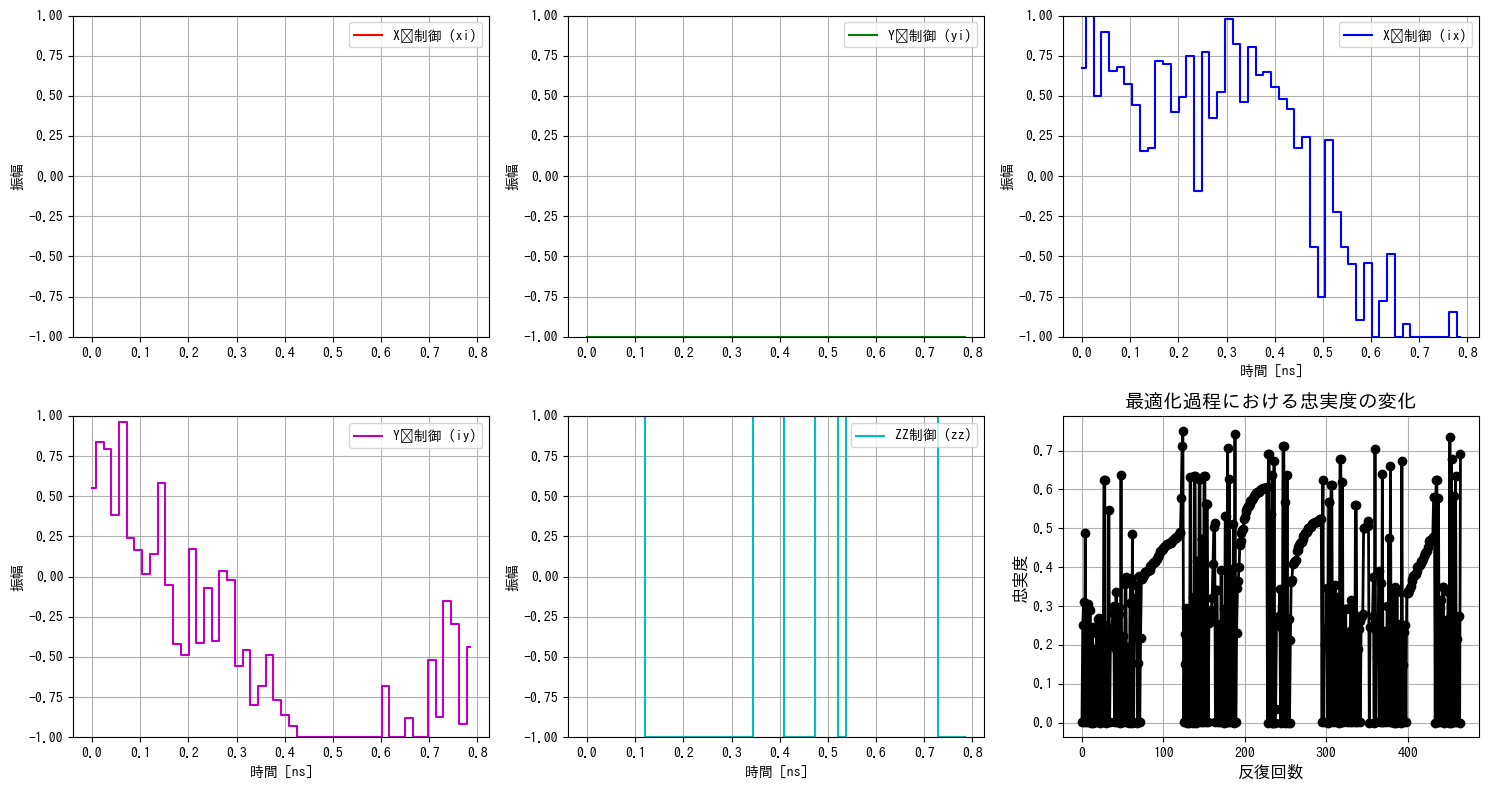

In [59]:
# 最適化されたパルスを取得
optimized_pulses = [
    result.x[:n_steps],
    result.x[n_steps:2*n_steps],
    result.x[2*n_steps:3*n_steps],
    result.x[3*n_steps:4*n_steps],
    result.x[4*n_steps:5*n_steps]
]

# 初期値から最終値までの改善を表示
initial_fidelity = history[0] if history else 0
final_fidelity = history[-1] if history else 0
print(f"初期忠実度: {initial_fidelity:.6f}")
print(f"最終忠実度: {final_fidelity:.6f}")
print(f"改善率: {(final_fidelity - initial_fidelity) * 100:.2f}%")

# 最適化されたパルスと忠実度履歴を表示
time_grid = np.linspace(0, total_time, n_steps)
fig = plt.figure(figsize=(15,8))

# 5つのコントロールパルスを表示
control_labels = ['X₁制御 (xi)', 'Y₁制御 (yi)', 'X₂制御 (ix)', 'Y₂制御 (iy)', 'ZZ制御 (zz)']
colors = ['r', 'g', 'b', 'm', 'c']

# 左側に最適化されたパルスのサブプロット（2行2列）
for i in range(4):
    ax = plt.subplot(2, 3, i+1)
    ax.step(time_grid, optimized_pulses[i], f'{colors[i]}-', where='mid', label=control_labels[i])
    ax.set_ylabel('振幅')
    ax.set_ylim(pulse_bounds[0])
    ax.legend()
    ax.grid(True)
    if i >= 2:  # 下の行のプロットには時間軸ラベルを追加
        ax.set_xlabel('時間 [ns]')

# ZZ制御用の追加プロット
ax5 = plt.subplot(2, 3, 5)
ax5.step(time_grid, optimized_pulses[4], f'{colors[4]}-', where='mid', label=control_labels[4])
ax5.set_ylabel('振幅')
ax5.set_xlabel('時間 [ns]')
ax5.set_ylim(pulse_bounds[0])
ax5.legend()
ax5.grid(True)

# 右側に忠実度履歴のサブプロット
ax_fidelity = plt.subplot(2, 3, 6)
ax_fidelity.plot(history, 'o-k', linewidth=2)
ax_fidelity.set_xlabel('反復回数', fontsize=12)
ax_fidelity.set_ylabel('忠実度', fontsize=12)
ax_fidelity.set_title('最適化過程における忠実度の変化', fontsize=14)
ax_fidelity.grid(True)

plt.tight_layout()
plt.show()